## Data Exploration

In [1]:
import os
path2test = "./data/test_set/"
imgsList = [pp for pp in os.listdir(path2test) if "Annotation" not in pp]
print("number of images:", len(imgsList))


number of images: 336


In [2]:
import numpy as np
np.random.seed(2019)
rndImgs = np.random.choice(imgsList,4)
rndImgs

array(['154_HC.png', '245_HC.png', '299_HC.png', '232_HC.png'],
      dtype='<U11')

## Creating the Model

In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:

class SegNet(nn.Module):
    def __init__(self, params):
        super(SegNet, self).__init__()
        
        C_in, H_in, W_in = params["input_shape"]
        init_f = params["initial_filters"] 
        num_outputs = params["num_outputs"] 

        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(8*init_f, 16*init_f, kernel_size=3,padding=1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up1 = nn.Conv2d(16*init_f, 8*init_f, kernel_size=3,padding=1)
        self.conv_up2 = nn.Conv2d(8*init_f, 4*init_f, kernel_size=3,padding=1)
        self.conv_up3 = nn.Conv2d(4*init_f, 2*init_f, kernel_size=3,padding=1)
        self.conv_up4 = nn.Conv2d(2*init_f, init_f, kernel_size=3,padding=1)

        self.conv_out = nn.Conv2d(init_f, num_outputs , kernel_size=3,padding=1)    
    
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv5(x))

        x = self.upsample(x)
        x = F.relu(self.conv_up1(x))

        x = self.upsample(x)
        x = F.relu(self.conv_up2(x))
        
        x = self.upsample(x)
        x = F.relu(self.conv_up3(x))
        
        x = self.upsample(x)
        x = F.relu(self.conv_up4(x))

        x = self.conv_out(x)
        
        return x 

In [5]:
h,w = 128,192
params_model = {
        "input_shape": (1,h,w),
        "initial_filters": 16, 
        "num_outputs": 1,
            }

model = SegNet(params_model)

In [7]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [8]:
import matplotlib.pylab as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries

def show_img_mask(img, mask):
    
    img_mask = mark_boundaries(np.array(img), 
                        np.array(mask),
                        outline_color=(0,1,0),
                        color=(0,1,0))
    plt.imshow(img_mask)
    

In [9]:
path2weights = "./models/weights.pt"
model.load_state_dict(torch.load(path2weights))
model.eval()

SegNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode=bilinear)
  (conv_up1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

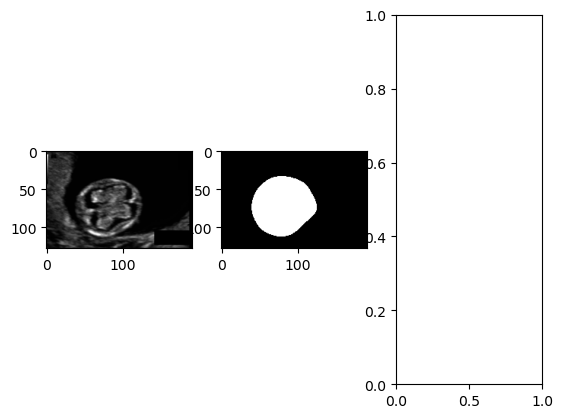

In [12]:
from torchvision.transforms.functional import to_tensor, to_pil_image

path2train = "./data/training_test/"

for fn in rndImgs:
    path2img = os.path.join(path2test, fn)
    img = Image.open(path2img)
    img = img.resize((w,h))
    img_t = to_tensor(img).unsqueeze(0).to(device)
    
    pred = model(img_t)
    pred = torch.sigmoid(pred)[0]
    mask_pred = (pred[0]>=0.5)

    plt.figure()
    plt.subplot(1, 3, 1) 
    plt.imshow(img, cmap="gray")

    plt.subplot(1, 3, 2) 
    plt.imshow(mask_pred.cpu(), cmap="gray")
    
    plt.subplot(1, 3, 3) 
    show_img_mask(img, mask_pred.cpu())
